<a href="https://colab.research.google.com/github/joseop/ProyectoIA/blob/main/01%20-%20ProyectoIA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A continuacion instalamos y cargamos las opciones necesarias para cargar el dataset desde la plataforma de kaggle con nuestro usuario registrado en la competicion

In [1]:
!pip install -q kaggle 

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"joseortizp","key":"6b3c9b6aa559814d7f47d457af4480fb"}'}

In [3]:
!mkdir ~/.kaggle

In [4]:
!cp kaggle.json ~/.kaggle/

In [5]:
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle competitions download -c home-credit-default-risk 

 98% 675M/688M [00:05<00:00, 144MB/s]
100% 688M/688M [00:05<00:00, 127MB/s]


In [7]:
!unzip home-credit-default-risk.zip

Archive:  home-credit-default-risk.zip
  inflating: HomeCredit_columns_description.csv  
  inflating: POS_CASH_balance.csv    
  inflating: application_test.csv    
  inflating: application_train.csv   
  inflating: bureau.csv              
  inflating: bureau_balance.csv      
  inflating: credit_card_balance.csv  
  inflating: installments_payments.csv  
  inflating: previous_application.csv  
  inflating: sample_submission.csv   


In [8]:
# Importar las bibliotecas necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.impute import SimpleImputer


In [9]:
# Cargar los conjuntos de datos
application_train = pd.read_csv('application_train.csv')
application_test = pd.read_csv('application_test.csv')
bureau = pd.read_csv('bureau.csv')
bureau_balance = pd.read_csv('bureau_balance.csv')
credit_card_balance = pd.read_csv('credit_card_balance.csv')
installments_payments = pd.read_csv('installments_payments.csv')
POS_CASH_balance = pd.read_csv('POS_CASH_balance.csv')
previous_application = pd.read_csv('previous_application.csv')

In [10]:
# Agrupe por la identificación del cliente (SK_ID_CURR), cuente la cantidad de préstamos anteriores 
previous_loan_counts = bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(columns = {'SK_ID_BUREAU': 'previous_loan_counts'})
previous_loan_counts.head()

,SK_ID_CURR,previous_loan_counts
0,100001,7
1,100002,8
2,100003,4
3,100004,2
4,100005,3


In [11]:
application_train = application_train.merge(previous_loan_counts, on = 'SK_ID_CURR', how = 'left')

# Rellena los valores que faltan con 0
application_train['previous_loan_counts'] = application_train['previous_loan_counts'].fillna(0)
application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,previous_loan_counts
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,8.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


# **Evaluación de la utilidad de la nueva variable con valor r**




Para determinar si la nueva variable es útil, podemos calcular el coeficiente de correlación de Pearsom (valor r) entre esta variable y el objetivo. Esto mide la fuerza de una relación lineal entre dos variables y varía de -1 (perfectamente lineal negativo) a +1 (perfectamente lineal positivo). El valor r no es la mejor medida de la "utilidad" de una nueva variable, pero puede dar una primera aproximación de si una variable será útil para un modelo de aprendizaje automático. Cuanto mayor sea el valor r de una variable con respecto al objetivo, es más probable que un cambio en esta variable afecte el valor del objetivo. Por lo tanto, buscamos las variables con el mayor valor absoluto r-valor en relación con el objetivo.

También podemos inspeccionar visualmente una relación con el objetivo mediante el gráfico de estimación de densidad del kernel (KDE).

# **Gráficos de estimación de densidad del kernel**

La gráfica de estimación de densidad kernel muestra la distribución de una sola variable (piense en ello como un histograma suavizado). Para ver las diferentes distribuciones que dependen del valor de una variable categórica, podemos colorear las distribuciones de manera diferente según la categoría. Por ejemplo, podemos mostrar la estimación de la densidad del kernel de los recuentos_de_préstamos_previos coloreados según si el objetivo = 1 o 0. El KDE resultante mostrará cualquier diferencia significativa en la distribución de la variable entre las personas que no pagaron su préstamo (OBJETIVO == 1 ) y las personas que lo hicieron (OBJETIVO == 0). Esto puede servir como indicador de si una variable será "relevante" para un modelo de aprendizaje automático.

Pondremos esta funcionalidad de trazado en una función para reutilizar para cualquier variable.

In [12]:
# Traza la distribución de una variable coloreada por el valor del objetivo
def kde_target(var_name, df):
    
    # Calcular el coeficiente de correlación entre la nueva variable y el objetivo
    corr = df['TARGET'].corr(df[var_name])
    
    # Calcule las medianas de reembolsado frente a no reembolsado
    avg_repaid = df.loc[df['TARGET'] == 0, var_name].median()
    avg_not_repaid = df.loc[df['TARGET'] == 1, var_name].median()
    
    plt.figure(figsize = (12, 6))
    
    # Traza la distribución para target == 0 y target == 1
    sns.kdeplot(df.loc[df['TARGET'] == 0, var_name], label = 'TARGET == 0')
    sns.kdeplot(df.loc[df['TARGET'] == 1, var_name], label = 'TARGET == 1')
    
    # etiquetar la trama
    plt.xlabel(var_name); plt.ylabel('Density'); plt.title('%s Distribution' % var_name)
    plt.legend();
    
    # imprimir la correlación
    print('La correlación entre %s y el OBJETIVO es %0.4f' % (var_name, corr))
    # Imprimir valores promedio
    print('Valor medio del préstamo que no se devolvió = %0.4f' % avg_not_repaid)
    print('Valor medio del préstamo que se devolvió =     %0.4f' % avg_repaid)

La correlación entre EXT_SOURCE_3 y el OBJETIVO es -0.1789
Valor medio del préstamo que no se devolvió = 0.3791
Valor medio del préstamo que se devolvió =     0.5460


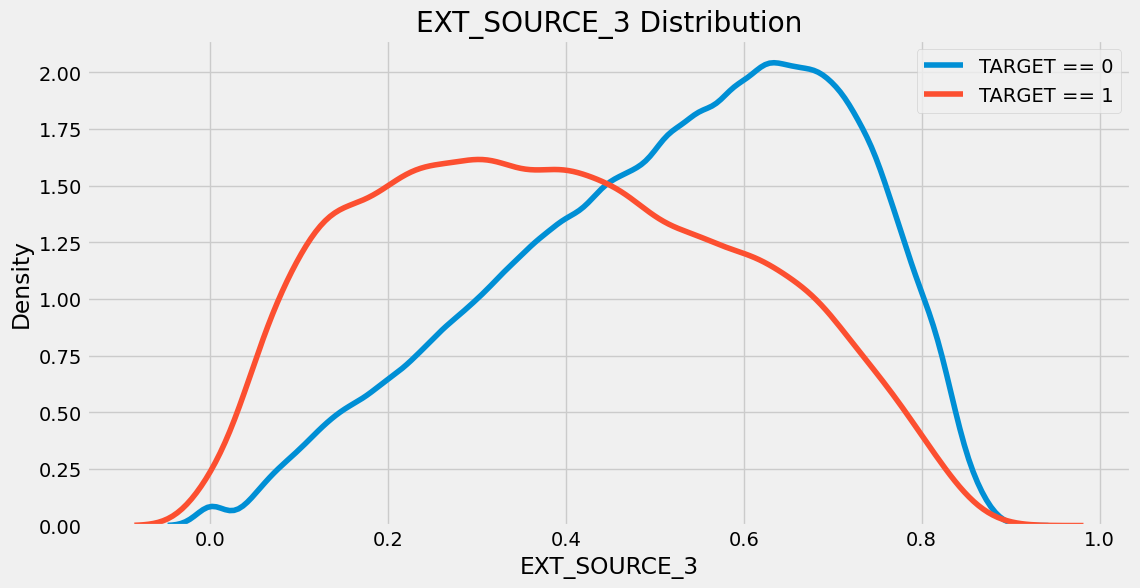

In [13]:
kde_target('EXT_SOURCE_3', application_train)

Agregar columnas numéricas
Para dar cuenta de la información numérica en el marco de datos de la oficina, podemos calcular estadísticas para todas las columnas numéricas. Para hacerlo, agrupamos por la identificación del cliente, agregamos el marco de datos agrupado y fusionamos el resultado nuevamente con los datos

In [14]:
bureau_agg = bureau.drop(columns = ['SK_ID_BUREAU']).groupby('SK_ID_CURR', as_index = False).\
            agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()
bureau_agg.head()

SK_ID_CURR DAYS_CREDIT                               CREDIT_DAY_OVERDUE  \
                   count         mean  max   min   sum              count   
0     100001           7  -735.000000  -49 -1572 -5145                  7   
1     100002           8  -874.000000 -103 -1437 -6992                  8   
2     100003           4 -1400.750000 -606 -2586 -5603                  4   
3     100004           2  -867.000000 -408 -1326 -1734                  2   
4     100005           3  -190.666667  -62  -373  -572                  3   

                ... DAYS_CREDIT_UPDATE                               \
  mean max min  ...              count        mean  max   min   sum   
0  0.0   0   0  ...                  7  -93.142857   -6  -155  -652   
1  0.0   0   0  ...                  8 -499.875000   -7 -1185 -3999   
2  0.0   0   0  ...                  4 -816.000000  -43 -2131 -3264   
3  0.0   0   0  ...                  2 -532.000000 -382  -682 -1064   
4  0.0   0   0  ...                  3  -54.333333  -11  -121  -163   

  AMT_ANNUITY                                      
        count         mean      max  min      sum  
0           7  3545.357143  10822.5  0.0  24817.5  
1           7     0.000000      0.0  0.0      0.0  
2           0          NaN      NaN  NaN      0.0  
3           0          NaN      NaN  NaN      0.0  
4           3  1420.500000   4261.5  0.0   4261.5  

[5 rows x 61 columns]

Necesitamos crear nuevos nombres para cada una de estas columnas. El siguiente código crea nuevos nombres agregando la estadística al nombre

In [15]:
columns = ['SK_ID_CURR']
for var in bureau_agg.columns.levels[0]:
    if var != 'SK_ID_CURR':        
        for stat in bureau_agg.columns.levels[1][:-1]:
            columns.append('bureau_%s_%s' % (var, stat))

In [16]:
# Asigne la lista de nombres de columnas como los nombres de columna del marco de datos
bureau_agg.columns = columns
bureau_agg.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


In [17]:
# Combinar datos 
application_train = application_train.merge(bureau_agg, on = 'SK_ID_CURR', how= 'left')
application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,8.0,-499.875,-7.0,-1185.0,-3999.0,7.0,0.0,0.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,4.0,-816.000,-43.0,-2131.0,-3264.0,0.0,NaN,NaN,NaN,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,2.0,-532.000,-382.0,-682.0,-1064.0,0.0,NaN,NaN,NaN,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,1.0,-783.000,-783.0,-783.0,-783.0,0.0,NaN,NaN,NaN,0.0


Podemos calcular la correlación de todos los valores nuevos con el objetivo. De nuevo, podemos utilizarlos como una aproximación de las variables que pueden ser importantes para el modelado.

In [18]:

new_corrs = []

for col in columns:
    corr = application_train['TARGET'].corr(application_train[col])
    new_corrs.append((col, corr))

In [19]:
new_corrs = sorted(new_corrs, key = lambda x: abs(x[1]), reverse = True)
new_corrs[:15]

[('bureau_DAYS_CREDIT_mean', 0.08972896721998114),
 ('bureau_DAYS_CREDIT_min', 0.0752482510301036),
 ('bureau_DAYS_CREDIT_UPDATE_mean', 0.06892735266968673),
 ('bureau_DAYS_ENDDATE_FACT_min', 0.05588737984392077),
 ('bureau_DAYS_CREDIT_ENDDATE_sum', 0.0537348956010205),
 ('bureau_DAYS_ENDDATE_FACT_mean', 0.05319962585758616),
 ('bureau_DAYS_CREDIT_max', 0.04978205463997299),
 ('bureau_DAYS_ENDDATE_FACT_sum', 0.048853502611115894),
 ('bureau_DAYS_CREDIT_ENDDATE_mean', 0.046982754334835494),
 ('bureau_DAYS_CREDIT_UPDATE_min', 0.042863922470730155),
 ('bureau_DAYS_CREDIT_sum', 0.041999824814846716),
 ('bureau_DAYS_CREDIT_UPDATE_sum', 0.04140363535306002),
 ('bureau_DAYS_CREDIT_ENDDATE_max', 0.036589634696329094),
 ('bureau_DAYS_CREDIT_ENDDATE_min', 0.034281109921616024),
 ('bureau_DAYS_ENDDATE_FACT_count', -0.030492306653325495)]

La correlación entre bureau_DAYS_CREDIT_mean y el OBJETIVO es 0.0897
Valor medio del préstamo que no se devolvió = -835.3333
Valor medio del préstamo que se devolvió =     -1067.0000


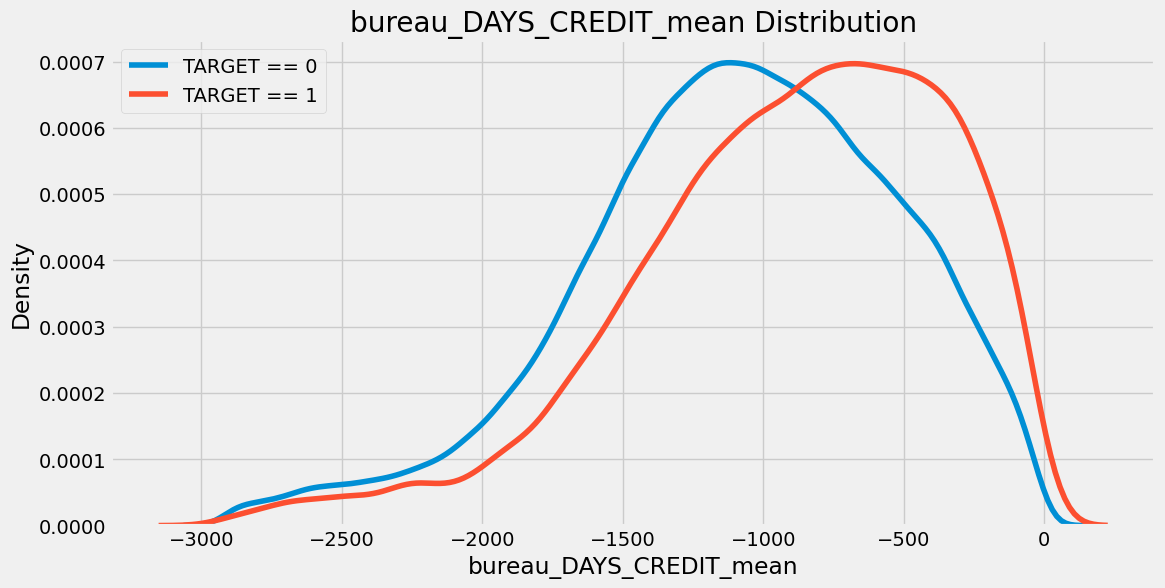

In [20]:
kde_target('bureau_DAYS_CREDIT_mean', application_train)

La correlación entre bureau_DAYS_CREDIT_mean y TARGET es 0.0897
Valor medio del préstamo que no se devolvió = -835,3333
Valor medio del préstamo que se reembolsó = -1067,0000

La interpretación es que esta es la cantidad de días que se solicitó el préstamo anterior antes de la solicitud de un préstamo en Home Credit. Por lo tanto, un número negativo mayor indica que el préstamo fue anterior a la solicitud de préstamo actual. Vemos una relación positiva extremadamente débil entre el promedio de esta variable y el objetivo, lo que significa que los clientes que solicitaron préstamos en el pasado tienen más posibilidades de pagar los préstamos en Home Credit.

In [21]:
# Agregar los valores numericos al dateframe 
def agg_numeric(df, group_var, df_name):
    # Eliminar la variable de identificacion
    for col in df:
        if col != group_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    group_ids = df[group_var]
    numeric_df = df.select_dtypes('number')
    numeric_df[group_var] = group_ids
    
    # Agrupe por variable especifica y calcule las estadisticas
    agg = numeric_df.groupby(group_var).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()
    
    # Crear nuevos nombres para la columna 
    columns = [group_var]
    
    # Iterar a traver de los nombres de las variables
    for var in agg.columns.levels[0]:
        if var != group_var:
            for stat in agg.columns.levels[1][:-1]:
                columns.append('%s_%s_%s' % (df_name, var, stat))
                
    agg.columns = columns
    return agg

In [22]:
bureau_agg_new = agg_numeric(bureau.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_agg_new.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


In [23]:
bureau_agg.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


Si revisamos e inspeccionamos el valor, encontramos que son equivalentes. Podremos reutilizar esta función para calcular estadísticas numéricas para otros marcos de datos.

Antes de continuar, también podemos hacer que el código calcule las correlaciones con el objetivo en una función.

In [24]:
def target_corrs(df):
    corrs = []
    
    for col in df.columns:
        print(col)
        if col != 'TARGET':
            corr = df['TARGET'].corr(df[col]) 
            corrs.append((col, corr))
        corrs = sorted(corrs, key = lambda x: abs(x[1]), reverse = True)
    
    return corrs


# Variables categóricas
Ahora pasamos de las columnas numéricas


---

Primero, codificamos en caliente un dataframe sin las columnas categóricas (dtype == 'objeto')

In [25]:
categorical = pd.get_dummies(bureau.select_dtypes('object'))
categorical['SK_ID_CURR'] = bureau['SK_ID_CURR']
categorical.head()

,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,CREDIT_CURRENCY_currency 1,CREDIT_CURRENCY_currency 2,CREDIT_CURRENCY_currency 3,CREDIT_CURRENCY_currency 4,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Car loan,...,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan,SK_ID_CURR
0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
1,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
2,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
3,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
4,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
